# Error Characterization of HERMES (Theory)
Understanding the sources of error of an integrator is essential for many reasons. It makes debugging much faster, adding new modules much easier, and the simulation of systems more efficient. In this tutorial we go through the gory details of calculating the error associated with a particle leaving the Hill sphere of a planet in HERMES, $E_{scheme}^{HERMES}$. Refer to Silburt et al. (2016) for details.

Here we will study is a restricted 3-body (R3B) system, consisting of an active central star, active planet and semi-active planetesimal. The planetesimal begins inside the $HSF$ boundary of the planet, and as it exits the Hill sphere we aim to calculate the error introduced into a simulation. 

We will use sympy to aid our computation (it's a lifesaver!). Do 'pip install sympy' if you don't already have it installed on your machine.

In [1]:
from sympy import *
init_printing()

## Setup
First, we must create the variables we will be using. Subscripts 0, 1 and 2 refer to the star, planetesimal and planet, respectively. Here we define:
* G = Gravitational Constant
* m = mass of body
* Q = Democratic Heliocentric position vector
* P = Democratic Heliocentric momentum vector
* x = Cartesian 'x' position
* y = Cartesian 'y' position
* px = Cartesian 'x' momentum
* py = Cartesian 'y' momentum
* O,f,g = Since eventually we want to work in the limit that m0>>m2>>m1, O represents 'order of magnitude', while f and g relate to m1 and m2, respectively and allow us to track which O's come from which mass.
* T = the timestep

In [27]:
#subscript 0 = star, 1 = planetesimal, 2 = planet
G,m0,O,f,g,T = symbols("G,m0,O,f,g,T")
Q0,Q1,Q2,P0,P1,P2 = symbols("Q0,Q1,Q2,P0,P1,P2")
x1,y1,x2,y2,px1,py1,px2,py2 = symbols("x1,y1,x2,y2,px1,py1,px2,py2")

In [3]:
#Create Democratic Heliocentric Position/Momentum vectors
m1 = O*O*f
m2 = O*g
mtot = (m0 + m1 + m2)

Q1 = sqrt(x1*x1 + y1*y1)
Q2 = sqrt(x2*x2 + y2*y2)
Q0 = (m1*Q1 + m2*Q2)/mtot

P0 = sqrt(px1*px1 + py1*py1) + sqrt(px2*px2 + py2*py2)
P1 = sqrt(px1*px1 + py1*py1) - m1*P0/mtot
P2 = sqrt(px2*px2 + py2*py2) - m2*P0/mtot

In [4]:
#Create Hamiltonian components - see Duncan et al. (1998) for equations
H_k = P1*P1/(2*m1) + P2*P2/(2*m2) - G*m1*m0/Q1 - G*m2*m0/Q2
H_s = (P1 + P2)**2/(2*m0)
H_i = -G*m1*m2/(Q2 - Q1)
H_B = H_s + H_i        #See Wisdom (2006) for why 

In [5]:
#uncomment the line below to see symbolic representation of these equations!
#H_B

## Calculate $H_{err}$

Up to this point, we have created the Hamiltonian for the system in Democratic Heliocentric components in two dimensions, expressing everything in terms of cartesian co-ordinates. We now calculate (e.g. Saha and Tremaine, 1992):

$$H_{err} = \frac{T^2}{12}\{\{H_k,H_B\},H_B + 0.5H_k \}$$

where $H_k$, and $H_B$ are defined above. We will carry forward the $T^2/12$ term until the very end.

In [6]:
D0 = diff(H_k,x1)*diff(H_B,px1) - diff(H_k,px1)*diff(H_B,x1) #first terms are 0
D1 = diff(H_k,y1)*diff(H_B,py1) - diff(H_k,py1)*diff(H_B,y1) 
D2 = diff(H_k,x2)*diff(H_B,px2) - diff(H_k,px2)*diff(H_B,x2) 
D3 = diff(H_k,y2)*diff(H_B,py2) - diff(H_k,py2)*diff(H_B,y2) 
D = D0+D1+D2+D3

B = 0.5*H_k + H_B
B0 = diff(D,x1)*diff(B,px1) - diff(D,px1)*diff(B,x1) #first terms are 0
B1 = diff(D,y1)*diff(B,py1) - diff(D,py1)*diff(B,y1) 
B2 = diff(D,x2)*diff(B,px2) - diff(D,px2)*diff(B,x2) 
B3 = diff(D,y2)*diff(B,py2) - diff(D,py2)*diff(B,y2)

result_raw = B0+B1+B2+B3

## Massaging/Simplifying
If you display result_raw, you'll see that it's one big mess (it will take a super long time to load too!).

This raw result needs to be greatly simplified. The remainder of this notebook constitute a number of massaging/simplifying steps to arrive at something meaningful. Since we are going to expand and simplify, we need to keep track of important terms, like $(r_2 - r_1)$. To do this, we make a symbolic substitution, setting $(r_2 - r_1) = H$. We also make a few assumptions:
* Order of magnitude limits, i.e. $x = y = r$, $vx = vy = v$, etc.
* Assume that $v_2 \approx v_1 = v$.
* $r_2 = a_2$, where $a_2$ is the semi-major axis of the planet and $r_2$ is the position of the planet (when e=0 this is exactly true).

In [19]:
#make a few initial substitutions to simplify the expression.
result = result_raw

r0,r1,r2,v,vx1,vy1,vx2,vy2,H,a2 = symbols("r0,r1,r2,v,vx1,vy1,vx2,vy2,H,a2")
result = result.subs({sqrt(x1**2 + y1**2):r1,sqrt(x2**2 + y2**2):r2,sqrt(px1**2 + py1**2):m1*v,sqrt(px2**2 + py2**2):m2*v})
result = result.subs({-r1 + r2:H,r1:a2-H,r2:a2})
result = result.subs({O**2*f + O*g + m0:m0, O**2*f*v + O*g*v:O*g*v})

In [20]:
#expand the expression
resulte = expand(result)

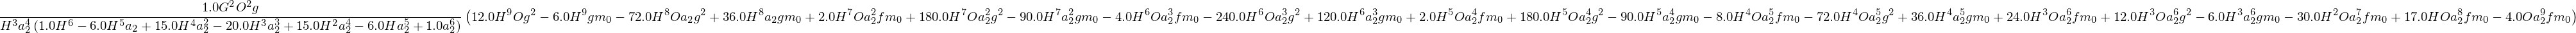

In [21]:
#assume order of magnitudes, i.e. x1 = y1 = r1, vx1 = vx2 = v, vy1 = vy2 = v
resulte = resulte.subs({x1:a2-H, y1:a2-H, x2:a2, y2:a2}) 
resulte = resulte.subs({px1:m1*v, py1:m1*v, px2:m2*v, py2:m2*v})

#Work in the limit of m0>>m2>>m1
resulte = resulte.subs({O**13:0,O**11:0,O**10:0,O**9:0,O**8:0,O**7:0,O**6:0,O**5:0,O**4:0})

#collect terms
resulte = collect(resulte,O)

#assume Keplerian velocity for both planet and planetesimal
resulte = simplify(resulte.subs({v**2:G*m0/a2, -H+a2:a2}))

resulte

Finally, since $H \ll a$, we take the leading term in parentheses (numerator and denominator), and add back the $T^2/12$ term, leaving us with:

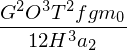

In [29]:
#take leading terms (H << a)
final = T**2*G**2*O**2*g*O*a2**9*f*m0/(12*H**3*a2**10)
final

This is analogous to the expression found in Silburt et al. (2016):

$$H_err = \frac{\tau^2}{12}\frac{G^2m_0m_1m_2}{a_2(r_{H,2}\kappa_{HSF})^3}$$